# Comparing a conventional and approximate Multioutput-Output GP

In [ ]:
import math

import torch
import gpytorch
from matplotlib import pyplot as plt

import famgpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {torch.cuda.get_device_name(device) if device.type == 'cuda' else 'CPU'}.")

## Set up some very simple training data

$$
\begin{align}
y_1 &= \sin(2\pi x) + \epsilon \\
y_2 &= \cos(2\pi x) + \epsilon \\
\epsilon &\sim \mathcal{N}(0, 0.04)
\end{align}
$$
With training and test examples regularly spaced points in [0,1]

In [ ]:
nb_training_points = 3000
nb_test_points = 2000

train_x = torch.linspace(0, 1, nb_training_points, device=device)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size(), device=device) * math.sqrt(0.04),
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size(), device=device) * math.sqrt(0.04),
], -1)

## Setting up the models
Both **GP Models** `gpytorch.models.ExactGP` with:
- **Likelihood** `gpytorch.likelihoods.GaussianLikelihood`
- **Zero Mean** `gpytorch.means.ZeroMean` for simplicity

One model witch conventional kernel:
- **RBF Kernel** `gpytorch.kernels.RBFKernel`

One model with approximate kernel:
- **Approximate RBF Kernel** `famgpytorch.kernels.RBFKernelApprox`

Mean and Covariance modules are wrapped by the corresponding multitask module:
- **MultitaskMean** `gpytorch.means.MultitaskMean`: one mean for each task
- **MultitaskKernel** `gpytorch.kernels.MultitaskKernel`: Kernel supporting Kronecker style multitask Gaussian processes
    - $K = K_{TT} \otimes K_{XX}$

In [ ]:
class ConventionalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ConventionalGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

class ApproxGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ApproxGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = famgpytorch.kernels.MultitaskKernelApprox(
            famgpytorch.kernels.RBFKernelApprox(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

conv_likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
conv_likelihood.to(device)
conv_model = ConventionalGPModel(train_x, train_y, conv_likelihood)
conv_model.to(device)

approx_likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
approx_likelihood.to(device)
approx_model = ApproxGPModel(train_x, train_y, approx_likelihood)
approx_model.to(device)

# manually initialize task kernel hyperparameters to make GPs comparable
covar_factor = torch.randn(*conv_model.covar_module.task_covar_module.batch_shape, 2, 1, device=device)
var = torch.randn(*conv_model.covar_module.task_covar_module.batch_shape, 2, device=device)
hypers = {
    "covar_module.task_covar_module.covar_factor": covar_factor,
    "covar_module.task_covar_module.raw_var": var
}
conv_model.initialize(**hypers)
approx_model.initialize(**hypers)
None

## Training the model

In [4]:
# set model in training mode
conv_model.train()
approx_model.train()
conv_likelihood.train()
approx_likelihood.train()

# use adam optimizer, including the GaussianLikelihood parameters
conv_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.01)
approx_optimizer = torch.optim.Adam(approx_model.parameters(), lr=0.01)

# "Loss" for GPs - marginal log likelihood
conv_mll = gpytorch.mlls.ExactMarginalLogLikelihood(conv_likelihood, conv_model)
approx_mll = gpytorch.mlls.ExactMarginalLogLikelihood(approx_likelihood, approx_model)

print("Conventional:")
for i in range(50):
    conv_optimizer.zero_grad()
    conv_output = conv_model(train_x)
    conv_loss = -conv_mll(conv_output, train_y)
    conv_loss.backward()
    if i == 0 or (i + 1) % 10 == 0:
        task_noises = approx_model.likelihood.task_noises.tolist()
        print(
            f"\tIter {i + 1:02d}/50   "
            f"Loss: {' ' if conv_loss.item() >= 0 else ''}{conv_loss.item():.3f}   "
            f"lengthscale: {conv_model.covar_module.data_covar_module.lengthscale.item():.3f}"
        )
    conv_optimizer.step()

print("Approximate")
for i in range(50):
    approx_optimizer.zero_grad()
    approx_output = approx_model(train_x)
    approx_loss = -approx_mll(approx_output, train_y)
    approx_loss.backward()
    if i == 0 or (i + 1) % 10 == 0:
        task_noises = approx_model.likelihood.task_noises.tolist()
        print(
            f"\tIter {i + 1:02d}/50   "
            f"Loss: {' ' if approx_loss.item() >= 0 else ''}{approx_loss.item():.3f}   "
            f"lengthscale: {approx_model.covar_module.data_covar_module.lengthscale.item():.3f}   "
            f"alpha: {approx_model.covar_module.data_covar_module.alpha.item():.3f}"
        )
    approx_optimizer.step()

	Iter 30/50   Loss:  1.011   lengthscale: 0.558
	Iter 40/50   Loss:  0.969   lengthscale: 0.517
	Iter 50/50   Loss:  0.927   lengthscale: 0.481
Approximate
tensor([0.6732, 1.6484, 0.6732,  ..., 1.6484, 0.6732, 1.6484], device='cuda:0')
	Iter 01/50   Loss:  1.128   lengthscale: 0.693   alpha: 0.693
tensor([0.6870, 1.6744, 0.6870,  ..., 1.6744, 0.6870, 1.6744], device='cuda:0')
tensor([0.7010, 1.7005, 0.7010,  ..., 1.7005, 0.7010, 1.7005], device='cuda:0')
tensor([0.7153, 1.7268, 0.7153,  ..., 1.7268, 0.7153, 1.7268], device='cuda:0')
tensor([0.7299, 1.7531, 0.7299,  ..., 1.7531, 0.7299, 1.7531], device='cuda:0')
tensor([0.7447, 1.7795, 0.7447,  ..., 1.7795, 0.7447, 1.7795], device='cuda:0')
tensor([0.7598, 1.8058, 0.7598,  ..., 1.8058, 0.7598, 1.8058], device='cuda:0')
tensor([0.7752, 1.8322, 0.7752,  ..., 1.8321, 0.7752, 1.8321], device='cuda:0')
tensor([0.7908, 1.8584, 0.7908,  ..., 1.8584, 0.7908, 1.8584], device='cuda:0')
tensor([0.8068, 1.8845, 0.8068,  ..., 1.8845, 0.8068, 1.8845]

## Resulting covariance matrix

	covar:	 tensor([[ 1.4807, -1.5081,  1.4807,  ..., -0.1695,  0.1662, -0.1693],
					 [-1.5081,  2.7879, -1.5081,  ...,  0.3134, -0.1693,  0.3129],
					 [ 1.4807, -1.5081,  1.4807,  ..., -0.1698,  0.1664, -0.1695],
					 ...,
					 [-0.1695,  0.3134, -0.1698,  ...,  2.7879, -1.5081,  2.7879],
					 [ 0.1662, -0.1693,  0.1664,  ..., -1.5081,  1.4807, -1.5081],
					 [-0.1693,  0.3129, -0.1695,  ...,  2.7879, -1.5081,  2.7879]],
       device='cuda:0', grad_fn=<MatmulBackward>)

--Approximate--
	covar:	 tensor([[ 1.4825, -1.5077,  1.4825,  ..., -0.1695,  0.1664, -0.1692],
					 [-1.5077,  2.7812, -1.5077,  ...,  0.3126, -0.1692,  0.3122],
					 [ 1.4825, -1.5077,  1.4825,  ..., -0.1697,  0.1666, -0.1695],
					 ...,
					 [-0.1695,  0.3126, -0.1697,  ...,  2.7812, -1.5077,  2.7812],
					 [ 0.1664, -0.1692,  0.1666,  ..., -1.5077,  1.4825, -1.5077],
					 [-0.1692,  0.3122, -0.1695,  ...,  2.7812, -1.5077,  2.7812]],
       device='cuda:0', grad_fn=<MatmulBackward>)

RMSE: tensor(0.0027,

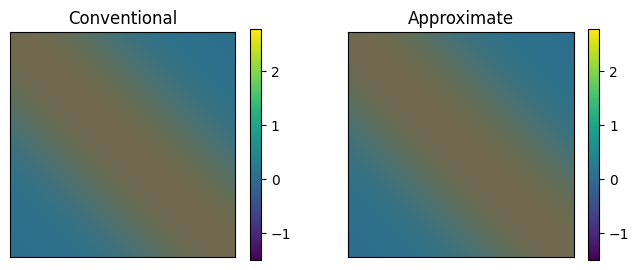

In [5]:
with torch.no_grad():
    conv_f_train = conv_model(train_x)
    conv_train_covar = conv_f_train.covariance_matrix
    print("\tcovar:\t", conv_train_covar.__repr__().replace(
        '\n        ',
        '\n' + 5*'\t' + ' '
    ))

    print("\n--Approximate--")
    approx_f_train = approx_model(train_x)
    approx_train_covar = approx_f_train.covariance_matrix
    print("\tcovar:\t", approx_train_covar.__repr__().replace(
        '\n        ',
        '\n' + 5*'\t' + ' '
    ))

    rmse = torch.sqrt(torch.mean((conv_train_covar - approx_train_covar)**2))
    print("\nRMSE:", rmse)

    # plot matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

    conv_train_covar = conv_train_covar.to('cpu')
    approx_train_covar = conv_train_covar.to('cpu')
    vmin = torch.min(torch.cat((conv_train_covar, approx_train_covar))).item()
    vmax = torch.max(torch.cat((conv_train_covar, approx_train_covar))).item()
    # -- Conventional
    im1 = ax1.imshow(conv_train_covar.numpy(), cmap=plt.colormaps['viridis'], vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im1, ax=ax1)
    ax1.set_title("Conventional")
    ax1.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
    ax1.grid(False)

    # -- Approximate
    im2 = ax2.imshow(approx_train_covar.numpy(), cmap=plt.colormaps['viridis'], vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im2, ax=ax2)
    ax2.set_title("Approximate")
    ax2.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
    ax2.grid(False)

## Make predictions with the models

tensor([1.4825, 2.7812, 1.4825,  ..., 2.7812, 1.4825, 2.7812], device='cuda:0')
tensor([1.4825, 2.7812, 1.4825,  ..., 2.7812, 1.4825, 2.7812], device='cuda:0')


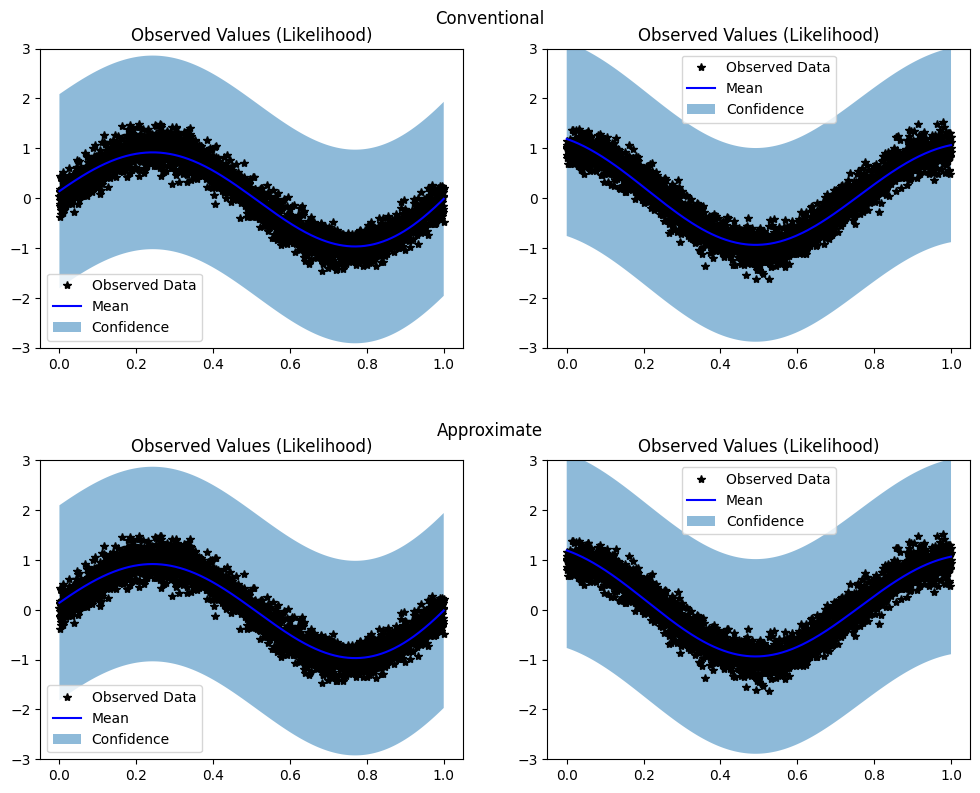

In [6]:
# Set into eval mode
conv_model.eval()
conv_likelihood.eval()
approx_model.eval()
approx_likelihood.eval()

# Make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, nb_test_points, device=device)

    conv_predictions = conv_likelihood(conv_model(test_x))
    approx_predictions = approx_likelihood(approx_model(test_x))

    # This contains predictions for both tasks, flattened out
    # The first half of the predictions is for the first task
    # The second half is for the second task

# Initialize plots
f = plt.figure(figsize=(12, 8))
subfigs = f.subfigures(2, 1, hspace=0.06)
subfigs[0].suptitle("Conventional")
subfigs[1].suptitle("Approximate")
for row, predictions in enumerate([conv_predictions, approx_predictions]):
    mean = predictions.mean.to('cpu')
    lower, upper = (tensor.to('cpu') for tensor in predictions.confidence_region())
    train_x = train_x.to('cpu')
    train_y = train_y.to('cpu')
    test_x = test_x.to('cpu')

    y1_ax, y2_ax = subfigs[row].subplots(1, 2)
    # Plot training data as black stars
    y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
    # Predictive mean as blue line
    y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
    # Shade in confidence
    y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
    y1_ax.set_ylim([-3, 3])
    y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y1_ax.set_title('Observed Values (Likelihood)')

    # Plot training data as black stars
    y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
    # Predictive mean as blue line
    y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
    # Shade in confidence
    y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
    y2_ax.set_ylim([-3, 3])
    y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y2_ax.set_title('Observed Values (Likelihood)')